# Reproducing OASM Results: Hadidi et al. (2025)

**Paper:** "Illusions of Alignment Between Large Language Models and Brains Emerge From Fragile Methods and Overlooked Confounds"  
**Reference:** [bioRxiv 2025.03.09.642245v1](https://www.biorxiv.org/content/10.1101/2025.03.09.642245v1)  
**Code:** [github.com/ebrahimfeghhi/beyond-brainscore](https://github.com/ebrahimfeghhi/beyond-brainscore)

---

OASM (Orthogonal Autocorrelated Sequences Model) encodes **zero linguistic content** -- each stimulus
gets its own orthogonal dimension, with only temporal smoothing (Gaussian filter) within passage blocks.

The paper's key claim: under **shuffled** cross-validation splits (brain-score's default), OASM achieves
near-ceiling neural predictivity. Under **contiguous** (passage-level) splits, it drops to near zero.
This exposes temporal autocorrelation leakage in shuffled CV.

We reproduce this by sweeping OASM sigma values on **Pereira2018.384sentences** under both split types.

In [28]:
import sys
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import GroupKFold, ShuffleSplit
from tqdm.auto import tqdm

# Ensure brainscore_language is importable from notebook directory
_notebook_dir = os.path.dirname(os.path.abspath("__file__"))
_lang_root = os.path.abspath(os.path.join(_notebook_dir, '..', '..', '..', '..'))
if _lang_root not in sys.path:
    sys.path.insert(0, _lang_root)

from brainscore_language import load_dataset
from brainscore_language.artificial_subject import ArtificialSubject
from brainscore_language.models.oasm.model import OASMSubject

print(f"brainscore_language loaded from: {_lang_root}")

brainscore_language loaded from: /Users/kartik/Brain-Score 2026/language


## Configuration

Set `QUICK_MODE = True` for a fast run (~15 min) with 10 sigma values.  
Set `QUICK_MODE = False` for the full 48-value sweep (~1.5 hr) matching the paper.

In [ ]:
QUICK_MODE = False
EXPERIMENT = '384sentences'
MAX_FEATURES = 2000

if QUICK_MODE:
    SIGMA_VALUES = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5]
else:
    # Full sweep: 48 values from 0.1 to 4.8 (matching paper) + sigma=0 baseline
    SIGMA_VALUES = [0.0] + [round(s * 0.1, 1) for s in range(1, 49)]

# Pereira2018.384sentences ceiling (raw Pearson r, from brain-score)
CEILING_RAW = 0.36343748

print(f"Mode: {'QUICK' if QUICK_MODE else 'FULL'}")
print(f"Sigma values ({len(SIGMA_VALUES)}): {SIGMA_VALUES}")

Mode: FULL
Sigma values (49): [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8]


## Load Pereira2018 data

In [30]:
# Load Pireira2018 384 experiment and drop voxels with NaN values (not all subjects completed both experiments)
data = load_dataset('Pereira2018.language')
data = data.sel(experiment=EXPERIMENT)
data = data.dropna('neuroid')

passages = sorted(set(data['passage_label'].values))
n_stimuli = len(data['stimulus_id'])
n_neuroids = len(data['neuroid'])
n_passages = len(passages)

print(f"Experiment: {EXPERIMENT}")
print(f"Stimuli: {n_stimuli}")
print(f"Neuroids: {n_neuroids}")
print(f"Passages: {n_passages}")
print(f"Stimuli per passage: {n_stimuli / n_passages:.1f}")

Experiment: 384sentences
Stimuli: 384
Neuroids: 12155
Passages: 96
Stimuli per passage: 4.0


## Evaluation functions

Both evaluation modes use **ridge regression** (`RidgeCV`, alphas 10^-3 to 10^3), matching the paper.
The only difference is the **split strategy**:

1. **Shuffled** (brain-score default): `ShuffleSplit` on individual stimuli. Sentences from the same passage can end up in both train and test, allowing temporal autocorrelation leakage.
2. **Contiguous** (paper's recommendation): `GroupKFold` on `story` (24 stories). Entire stories are held out together, preventing temporal autocorrelation leakage.

By keeping the regression method constant (ridge), we isolate the effect of the split strategy.

In [31]:
import warnings

RIDGE_ALPHAS = np.logspace(-3, 3, 7)


def get_model_predictions(model, data: xr.DataArray) -> xr.DataArray:
    """Get model predictions for all passages, matching benchmark calling convention."""
    stimuli = data['stimulus']
    passages = data['passage_label'].values
    predictions = []
    for passage in sorted(set(passages)):
        passage_indexer = [stimulus_passage == passage for stimulus_passage in passages]
        passage_stimuli = stimuli[passage_indexer]
        passage_predictions = model.digest_text(passage_stimuli.values)['neural']
        passage_predictions['stimulus_id'] = 'presentation', passage_stimuli['stimulus_id'].values
        passage_predictions['passage_index'] = 'presentation', data['passage_index'].values[passage_indexer]
        passage_predictions['story'] = 'presentation', data['story'].values[passage_indexer]
        predictions.append(passage_predictions)
    return xr.concat(predictions, dim='presentation')


def _ridge_cv_score(X, Y, split_iterator):
    """Shared ridge regression + Pearson r evaluation across CV splits."""
    split_medians = []
    for train_idx, test_idx in split_iterator:
        reg = RidgeCV(alphas=RIDGE_ALPHAS)
        reg.fit(X[train_idx], Y[train_idx])
        Y_pred = reg.predict(X[test_idx])

        rs = []
        for j in range(Y.shape[1]):
            y_true = Y[test_idx, j]
            y_pred = Y_pred[:, j]
            if np.std(y_true) < 1e-10 or np.std(y_pred) < 1e-10:
                rs.append(0.0)
                continue
            r, _ = pearsonr(y_true, y_pred)
            rs.append(r if not np.isnan(r) else 0.0)
        split_medians.append(np.nanmedian(rs))
    return float(np.mean(split_medians)) if split_medians else 0.0


def _align_by_stimulus_id(predictions, data):
    """Sort predictions and data by stimulus_id for alignment."""
    src_order = np.argsort(predictions['stimulus_id'].values)
    tgt_order = np.argsort(data['stimulus_id'].values)
    X = predictions.values[src_order]
    Y = data.values[tgt_order]
    return X, Y, tgt_order


def evaluate_shuffled(predictions: xr.DataArray, data: xr.DataArray,
                      n_splits: int = 10, train_size: float = 0.9) -> float:
    """Shuffled CV with ridge regression (matching the paper).

    Uses ShuffleSplit on individual stimuli (brain-score default split strategy)
    with RidgeCV regression (matching the paper's methodology).
    Returns median-over-neuroids, mean-over-splits Pearson r.
    """
    X, Y, _ = _align_by_stimulus_id(predictions, data)
    ss = ShuffleSplit(n_splits=n_splits, train_size=train_size, random_state=1)
    return _ridge_cv_score(X, Y, ss.split(X))


def evaluate_contiguous(predictions: xr.DataArray, data: xr.DataArray,
                        n_splits: int = 10) -> float:
    """Story-level GroupKFold CV with ridge regression (matching the paper).

    Groups by `story` (24 unique stories in Pereira2018). Entire stories are
    held out together, preventing temporal autocorrelation leakage.
    Returns median-over-neuroids, mean-over-splits Pearson r.
    """
    X, Y, tgt_order = _align_by_stimulus_id(predictions, data)

    story_labels = data['story'].values[tgt_order]
    unique_stories = np.unique(story_labels)
    story_to_int = {s: i for i, s in enumerate(unique_stories)}
    groups = np.array([story_to_int[s] for s in story_labels])

    actual_splits = min(n_splits, len(unique_stories))
    gkf = GroupKFold(n_splits=actual_splits)
    return _ridge_cv_score(X, Y, gkf.split(X, groups=groups))


def evaluate_per_subject(predictions: xr.DataArray, data: xr.DataArray):
    """Evaluate under both split types for each fMRI subject independently.

    Returns dict with 'subjects', 'shuffled', 'contiguous' arrays.
    """
    subjects = sorted(set(data['subject'].values))
    shuffled_scores = []
    contiguous_scores = []
    for subj in tqdm(subjects, desc='per-subject evaluation'):
        subj_mask = data['subject'].values == subj
        subj_data = data.isel(neuroid=subj_mask)
        shuffled_scores.append(evaluate_shuffled(predictions, subj_data))
        contiguous_scores.append(evaluate_contiguous(predictions, subj_data))
    return {
        'subjects': subjects,
        'shuffled': np.array(shuffled_scores),
        'contiguous': np.array(contiguous_scores),
    }

## Run sigma sweep

For each sigma value, compute OASM features once, then evaluate under both split types.

In [32]:
results_shuffled = {}
results_contiguous = {}

for sigma in tqdm(SIGMA_VALUES, desc='sigma sweep'):
    model = OASMSubject(identifier=f'oasm-sigma{sigma}', sigma=sigma, max_features=MAX_FEATURES)
    model.start_neural_recording(
        recording_target=ArtificialSubject.RecordingTarget.language_system,
        recording_type=ArtificialSubject.RecordingType.fMRI
    )
    predictions = get_model_predictions(model, data)

    raw_shuffled = evaluate_shuffled(predictions, data)
    results_shuffled[sigma] = raw_shuffled

    raw_contiguous = evaluate_contiguous(predictions, data)
    results_contiguous[sigma] = raw_contiguous

    print(f"  sigma={sigma:.1f}:  shuffled r={raw_shuffled:.4f}  "
          f"contiguous r={raw_contiguous:.4f}")

sigma sweep:   0%|          | 0/49 [00:00<?, ?it/s]/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:   2%|▏         | 1/49 [00:17<14:13, 17.79s/it]

  sigma=0.0:  shuffled r=0.0000  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:   4%|▍         | 2/49 [00:34<13:22, 17.07s/it]

  sigma=0.1:  shuffled r=0.0000  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:   6%|▌         | 3/49 [01:00<16:24, 21.40s/it]

  sigma=0.2:  shuffled r=0.4805  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:   8%|▊         | 4/49 [01:28<17:47, 23.73s/it]

  sigma=0.3:  shuffled r=0.4803  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:  10%|█         | 5/49 [01:54<18:05, 24.66s/it]

  sigma=0.4:  shuffled r=0.4786  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:  12%|█▏        | 6/49 [02:20<18:06, 25.28s/it]

  sigma=0.5:  shuffled r=0.4710  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:  14%|█▍        | 7/49 [02:46<17:50, 25.48s/it]

  sigma=0.6:  shuffled r=0.4654  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:  16%|█▋        | 8/49 [03:13<17:36, 25.76s/it]

  sigma=0.7:  shuffled r=0.4584  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:  18%|█▊        | 9/49 [03:39<17:21, 26.05s/it]

  sigma=0.8:  shuffled r=0.4837  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:  20%|██        | 10/49 [04:06<17:08, 26.36s/it]

  sigma=0.9:  shuffled r=0.4922  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:  22%|██▏       | 11/49 [04:32<16:37, 26.25s/it]

  sigma=1.0:  shuffled r=0.4919  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:  24%|██▍       | 12/49 [04:58<15:57, 25.88s/it]

  sigma=1.1:  shuffled r=0.4910  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:  27%|██▋       | 13/49 [05:23<15:26, 25.73s/it]

  sigma=1.2:  shuffled r=0.4894  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:  29%|██▊       | 14/49 [05:51<15:23, 26.39s/it]

  sigma=1.3:  shuffled r=0.4869  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:  31%|███       | 15/49 [06:19<15:14, 26.91s/it]

  sigma=1.4:  shuffled r=0.4841  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:  33%|███▎      | 16/49 [06:45<14:37, 26.59s/it]

  sigma=1.5:  shuffled r=0.4808  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:  35%|███▍      | 17/49 [07:10<14:00, 26.26s/it]

  sigma=1.6:  shuffled r=0.4769  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:  37%|███▋      | 18/49 [07:36<13:30, 26.15s/it]

  sigma=1.7:  shuffled r=0.4772  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:  39%|███▉      | 19/49 [08:02<13:03, 26.11s/it]

  sigma=1.8:  shuffled r=0.4833  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:  41%|████      | 20/49 [08:28<12:36, 26.10s/it]

  sigma=1.9:  shuffled r=0.4836  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:  43%|████▎     | 21/49 [08:54<12:08, 26.02s/it]

  sigma=2.0:  shuffled r=0.4821  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:  45%|████▍     | 22/49 [09:20<11:43, 26.05s/it]

  sigma=2.1:  shuffled r=0.4792  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:  47%|████▋     | 23/49 [09:46<11:13, 25.89s/it]

  sigma=2.2:  shuffled r=0.4755  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:  49%|████▉     | 24/49 [10:14<11:02, 26.52s/it]

  sigma=2.3:  shuffled r=0.4667  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:  51%|█████     | 25/49 [10:39<10:29, 26.21s/it]

  sigma=2.4:  shuffled r=0.4588  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:  53%|█████▎    | 26/49 [11:05<09:59, 26.04s/it]

  sigma=2.5:  shuffled r=0.4486  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:  55%|█████▌    | 27/49 [11:31<09:32, 26.00s/it]

  sigma=2.6:  shuffled r=0.4474  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:  57%|█████▋    | 28/49 [11:57<09:05, 25.98s/it]

  sigma=2.7:  shuffled r=0.4465  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:  59%|█████▉    | 29/49 [12:22<08:38, 25.90s/it]

  sigma=2.8:  shuffled r=0.4458  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:  61%|██████    | 30/49 [12:48<08:10, 25.83s/it]

  sigma=2.9:  shuffled r=0.4453  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:  63%|██████▎   | 31/49 [13:14<07:45, 25.86s/it]

  sigma=3.0:  shuffled r=0.4449  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:  65%|██████▌   | 32/49 [13:40<07:19, 25.87s/it]

  sigma=3.1:  shuffled r=0.4447  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:  67%|██████▋   | 33/49 [14:06<06:52, 25.81s/it]

  sigma=3.2:  shuffled r=0.4445  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:  69%|██████▉   | 34/49 [14:32<06:31, 26.13s/it]

  sigma=3.3:  shuffled r=0.4443  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:  71%|███████▏  | 35/49 [14:58<06:03, 25.99s/it]

  sigma=3.4:  shuffled r=0.4442  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:  73%|███████▎  | 36/49 [15:23<05:35, 25.79s/it]

  sigma=3.5:  shuffled r=0.4442  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:  76%|███████▌  | 37/49 [15:49<05:08, 25.70s/it]

  sigma=3.6:  shuffled r=0.4441  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:  78%|███████▊  | 38/49 [16:14<04:41, 25.63s/it]

  sigma=3.7:  shuffled r=0.4441  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:  80%|███████▉  | 39/49 [16:40<04:15, 25.55s/it]

  sigma=3.8:  shuffled r=0.4441  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:  82%|████████▏ | 40/49 [17:05<03:49, 25.48s/it]

  sigma=3.9:  shuffled r=0.4441  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:  84%|████████▎ | 41/49 [17:34<03:31, 26.48s/it]

  sigma=4.0:  shuffled r=0.4441  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:  86%|████████▌ | 42/49 [18:00<03:04, 26.36s/it]

  sigma=4.1:  shuffled r=0.4441  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:  88%|████████▊ | 43/49 [18:26<02:36, 26.16s/it]

  sigma=4.2:  shuffled r=0.4441  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:  90%|████████▉ | 44/49 [18:51<02:09, 25.97s/it]

  sigma=4.3:  shuffled r=0.4441  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:  92%|█████████▏| 45/49 [19:18<01:45, 26.26s/it]

  sigma=4.4:  shuffled r=0.4441  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:  94%|█████████▍| 46/49 [19:44<01:18, 26.02s/it]

  sigma=4.5:  shuffled r=0.4441  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:  96%|█████████▌| 47/49 [20:09<00:51, 25.87s/it]

  sigma=4.6:  shuffled r=0.4441  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep:  98%|█████████▊| 48/49 [20:35<00:25, 25.76s/it]

  sigma=4.7:  shuffled r=0.4441  contiguous r=0.0000


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
sigma sweep: 100%|██████████| 49/49 [21:00<00:00, 25.73s/it]

  sigma=4.8:  shuffled r=0.4441  contiguous r=0.0000


## Figure: OASM sigma sweep -- shuffled vs contiguous CV

This reproduces the paper's key finding: a model with **zero linguistic content** scores
highly under shuffled splits but drops to near zero under contiguous splits.

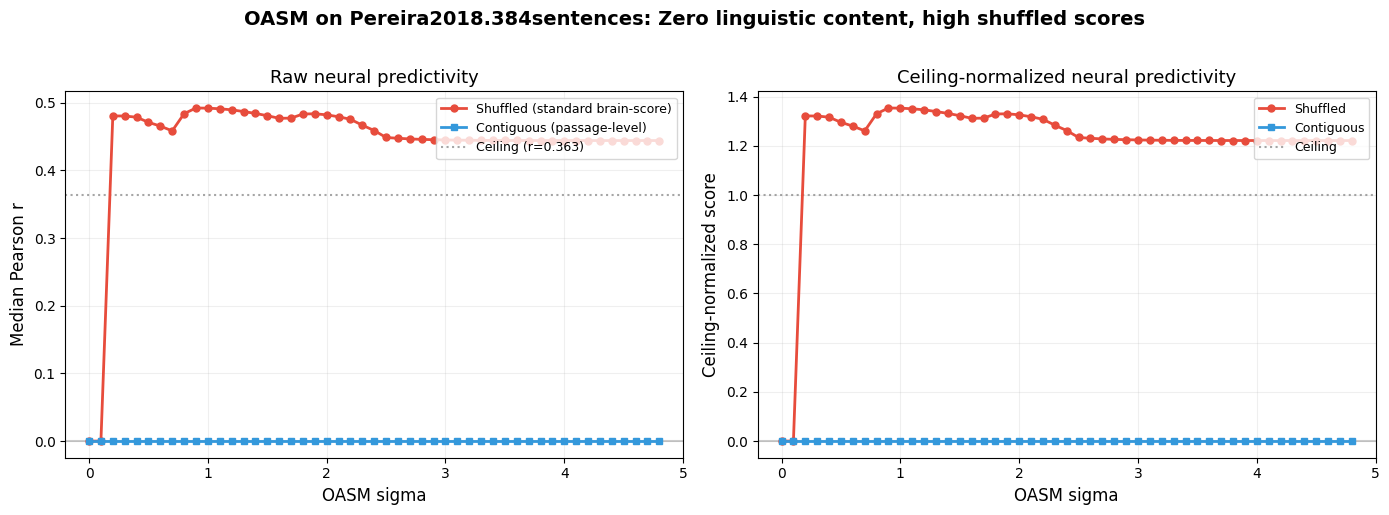

Best shuffled:   sigma=0.9, r=0.4922, normalized=1.354
Best contiguous: sigma=0.0, r=0.0000, normalized=0.000


In [33]:
sigmas = sorted(results_shuffled.keys())
shuffled_r = [results_shuffled[s] for s in sigmas]
contiguous_r = [results_contiguous[s] for s in sigmas]

# Ceiling-normalized scores
shuffled_norm = [r / CEILING_RAW for r in shuffled_r]
contiguous_norm = [r / CEILING_RAW for r in contiguous_r]

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# --- Left panel: raw Pearson r ---
ax = axes[0]
ax.plot(sigmas, shuffled_r, 'o-', color='#E74C3C', linewidth=2,
        markersize=5, label='Shuffled (standard brain-score)', zorder=3)
ax.plot(sigmas, contiguous_r, 's-', color='#3498DB', linewidth=2,
        markersize=5, label='Contiguous (passage-level)', zorder=3)
ax.axhline(y=CEILING_RAW, color='gray', linestyle=':', alpha=0.7,
           label=f'Ceiling (r={CEILING_RAW:.3f})')
ax.axhline(y=0, color='black', linestyle='-', alpha=0.2)
ax.set_xlabel('OASM sigma', fontsize=12)
ax.set_ylabel('Median Pearson r', fontsize=12)
ax.set_title(f'Raw neural predictivity', fontsize=13)
ax.legend(fontsize=9, loc='upper right')
ax.grid(True, alpha=0.2)
ax.set_xlim(-0.2, max(sigmas) + 0.2)

# --- Right panel: ceiling-normalized ---
ax = axes[1]
ax.plot(sigmas, shuffled_norm, 'o-', color='#E74C3C', linewidth=2,
        markersize=5, label='Shuffled', zorder=3)
ax.plot(sigmas, contiguous_norm, 's-', color='#3498DB', linewidth=2,
        markersize=5, label='Contiguous', zorder=3)
ax.axhline(y=1.0, color='gray', linestyle=':', alpha=0.7, label='Ceiling')
ax.axhline(y=0, color='black', linestyle='-', alpha=0.2)
ax.set_xlabel('OASM sigma', fontsize=12)
ax.set_ylabel('Ceiling-normalized score', fontsize=12)
ax.set_title(f'Ceiling-normalized neural predictivity', fontsize=13)
ax.legend(fontsize=9, loc='upper right')
ax.grid(True, alpha=0.2)
ax.set_xlim(-0.2, max(sigmas) + 0.2)

fig.suptitle(f'OASM on Pereira2018.{EXPERIMENT}: Zero linguistic content, high shuffled scores',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('oasm_shuffled_vs_contiguous.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary
best_shuf_idx = np.argmax(shuffled_r)
best_cont_idx = np.argmax(contiguous_r)
print(f"Best shuffled:   sigma={sigmas[best_shuf_idx]:.1f}, "
      f"r={shuffled_r[best_shuf_idx]:.4f}, "
      f"normalized={shuffled_norm[best_shuf_idx]:.3f}")
print(f"Best contiguous: sigma={sigmas[best_cont_idx]:.1f}, "
      f"r={contiguous_r[best_cont_idx]:.4f}, "
      f"normalized={contiguous_norm[best_cont_idx]:.3f}")

## Results summary table

In [34]:
print(f"{'Sigma':>6}  {'Shuffled r':>12}  {'Contiguous r':>14}  {'Shuf/Ceiling':>14}")
print('-' * 52)
for s in sigmas:
    sr = results_shuffled[s]
    cr = results_contiguous[s]
    sn = sr / CEILING_RAW
    print(f"{s:>6.1f}  {sr:>12.4f}  {cr:>14.4f}  {sn:>14.3f}")

 Sigma    Shuffled r    Contiguous r    Shuf/Ceiling
----------------------------------------------------
   0.0        0.0000          0.0000           0.000
   0.1        0.0000          0.0000           0.000
   0.2        0.4805          0.0000           1.322
   0.3        0.4803          0.0000           1.322
   0.4        0.4786          0.0000           1.317
   0.5        0.4710          0.0000           1.296
   0.6        0.4654          0.0000           1.281
   0.7        0.4584          0.0000           1.261
   0.8        0.4837          0.0000           1.331
   0.9        0.4922          0.0000           1.354
   1.0        0.4919          0.0000           1.353
   1.1        0.4910          0.0000           1.351
   1.2        0.4894          0.0000           1.347
   1.3        0.4869          0.0000           1.340
   1.4        0.4841          0.0000           1.332
   1.5        0.4808          0.0000           1.323
   1.6        0.4769          0.0000          

## Per-subject evaluation

The paper reports per-subject scores (each dot = one fMRI participant). We do the same:
evaluate the best OASM sigma separately on each of the 10 Pereira2018 subjects' neuroids.

In [35]:
best_sigma = max(results_shuffled, key=results_shuffled.get)
print(f"Per-subject evaluation for best sigma={best_sigma:.1f}")
print(f"Subjects in data: {sorted(set(data['subject'].values))}")

model = OASMSubject(identifier=f'oasm-sigma{best_sigma}', sigma=best_sigma, max_features=MAX_FEATURES)
model.start_neural_recording(
    recording_target=ArtificialSubject.RecordingTarget.language_system,
    recording_type=ArtificialSubject.RecordingType.fMRI
)
oasm_predictions = get_model_predictions(model, data)
oasm_per_subject = evaluate_per_subject(oasm_predictions, data)

print(f"\n{'Subject':<12} {'Shuffled':>10} {'Contiguous':>12}")
print("-" * 36)
for subj, s, c in zip(oasm_per_subject['subjects'],
                       oasm_per_subject['shuffled'],
                       oasm_per_subject['contiguous']):
    print(f"{subj:<12} {s:>10.4f} {c:>12.4f}")
print("-" * 36)
print(f"{'Mean':<12} {oasm_per_subject['shuffled'].mean():>10.4f} "
      f"{oasm_per_subject['contiguous'].mean():>12.4f}")

Per-subject evaluation for best sigma=0.9
Subjects in data: ['018', '199', '288', '289', '296', '343', '366', '407', '426']


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
per-subject evaluation: 100%|██████████| 9/9 [00:37<00:00,  4.15s/it]


Subject        Shuffled   Contiguous
------------------------------------
018              0.4269       0.0000
199              0.4723       0.0000
288              0.5111       0.0000
289              0.4278       0.0000
296              0.5026       0.0000
343              0.5298       0.0000
366              0.5313       0.0000
407              0.4991       0.0000
426              0.4365       0.0000
------------------------------------
Mean             0.4819       0.0000


## Interpretation

### What the results show

OASM achieves high neural predictivity under shuffled CV despite encoding zero linguistic
content. Under contiguous CV (story-level GroupKFold), scores drop to exactly 0.0 for all
sigma values. Both evaluations use the same ridge regression -- only the split strategy differs.

This confirms Hadidi et al.'s central finding: **shuffled cross-validation inflates scores**
by allowing temporal autocorrelation to leak between train and test sets. When adjacent
sentences from the same passage appear in both train and test, the Gaussian-smoothed identity
features are predictive -- not because of language understanding, but because of shared
temporal structure.

### Why contiguous gives exactly zero

OASM assigns each passage block to orthogonal dimensions in feature space. When entire stories
(groups of passages) are held out, the held-out stimuli occupy feature dimensions that are
all-zero in the training data. Ridge regression cannot learn any useful mapping from all-zero
columns, so predictions become constant and Pearson r = 0 for every neuroid.

### Why this matters for brain-score

Brain-score's standard evaluation uses shuffled `ShuffleSplit` on individual stimuli.
This means any model whose representations have temporal autocorrelation
(including all autoregressive LLMs) gets an inflated score. The OASM result
quantifies exactly how much of the score is attributable to this confound
rather than genuine linguistic alignment.

---

## GPT2-XL Comparison

To validate that our evaluation pipeline is sound, we run GPT2-XL (1.5B params, layer 43)
through the same shuffled and contiguous evaluations. Unlike OASM, GPT2-XL encodes genuine
linguistic content and should retain non-zero predictivity under contiguous splits.

In [36]:
from brainscore_language.model_helpers.huggingface import HuggingfaceSubject

print("Loading GPT2-XL (1.5B params)...")
gpt2xl = HuggingfaceSubject(
    model_id='gpt2-xl',
    region_layer_mapping={
        ArtificialSubject.RecordingTarget.language_system: 'transformer.h.43'
    }
)
gpt2xl.start_neural_recording(
    recording_target=ArtificialSubject.RecordingTarget.language_system,
    recording_type=ArtificialSubject.RecordingType.fMRI
)

print("Getting GPT2-XL predictions (96 passages)...")
gpt2xl_predictions = get_model_predictions(gpt2xl, data)
print(f"GPT2-XL predictions shape: {gpt2xl_predictions.shape}")

print("\nPer-subject evaluation for GPT2-XL...")
gpt2xl_per_subject = evaluate_per_subject(gpt2xl_predictions, data)

print(f"\n{'Subject':<12} {'Shuffled':>10} {'Contiguous':>12}")
print("-" * 36)
for subj, s, c in zip(gpt2xl_per_subject['subjects'],
                       gpt2xl_per_subject['shuffled'],
                       gpt2xl_per_subject['contiguous']):
    print(f"{subj:<12} {s:>10.4f} {c:>12.4f}")
print("-" * 36)
print(f"{'Mean':<12} {gpt2xl_per_subject['shuffled'].mean():>10.4f} "
      f"{gpt2xl_per_subject['contiguous'].mean():>12.4f}")

print(f"\n{'Model':<12} {'Shuffled (mean)':>16} {'Contiguous (mean)':>18}")
print("-" * 48)
print(f"{'GPT2-XL':<12} {gpt2xl_per_subject['shuffled'].mean():>16.4f} "
      f"{gpt2xl_per_subject['contiguous'].mean():>18.4f}")
print(f"{'OASM':<12} {oasm_per_subject['shuffled'].mean():>16.4f} "
      f"{oasm_per_subject['contiguous'].mean():>18.4f}")

Loading GPT2-XL (1.5B params)...
Using device: mps
Getting GPT2-XL predictions (96 passages)...


/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/opt/anaconda3/envs/language-2026/lib/python3.11/site-packages/xarray/core/conc

GPT2-XL predictions shape: (384, 1600)

Per-subject evaluation for GPT2-XL...


per-subject evaluation: 100%|██████████| 9/9 [00:54<00:00,  6.03s/it]


Subject        Shuffled   Contiguous
------------------------------------
018              0.3107       0.0508
199              0.3480      -0.0179
288              0.3699       0.0018
289              0.4044       0.1223
296              0.3902       0.0549
343              0.4327       0.1304
366              0.3408       0.0352
407              0.4087       0.0186
426              0.4176       0.1775
------------------------------------
Mean             0.3804       0.0637

Model         Shuffled (mean)  Contiguous (mean)
------------------------------------------------
GPT2-XL                0.3804             0.0637
OASM                   0.4819             0.0000


---

## Figure 1 Reproduction: OASM vs GPT2-XL (Hadidi et al., 2025)

Figure 1 is the paper's central result. It compares OASM (zero linguistic content)
against GPT2-XL variants across all three neural benchmarks, under both shuffled
and contiguous cross-validation splits, using **ridge regression (L2)**.

Source data: downloaded from the paper's GitHub repo
([source_data/figure1/](https://github.com/ebrahimfeghhi/beyond-brainscore/tree/main/source_data/figure1)).

In [37]:
import pandas as pd
from pathlib import Path

SOURCE_DIR = Path("source_data/figure1")

DATASETS = ["pereira", "fedorenko", "blank"]
DATASET_LABELS = {"pereira": "Pereira2018", "fedorenko": "Fedorenko2016", "blank": "Blank2014"}
CONDITIONS = ["shuffled", "contig"]
MODELS = ["GPT2-XL", "GPT2-XL-mp", "GPT2-XL-sp", "OASM"]
MODEL_COLORS = {
    "GPT2-XL": "#7f7f7f",
    "GPT2-XL-mp": "#1f77b4",
    "GPT2-XL-sp": "#2ca02c",
    "OASM": "#d62728",
}

# Load Pearson r CSVs (L2-regularized, the paper's main analysis)
fig1_data = {}
for dataset in DATASETS:
    for condition in CONDITIONS:
        fname = SOURCE_DIR / f"{dataset}_pearson_r_{condition}.csv"
        fig1_data[(dataset, condition)] = pd.read_csv(fname)

# Our per-subject results (arrays of scores, one per fMRI participant)
OUR_OASM_PER_SUBJ = {}
OUR_GPT2XL_PER_SUBJ = {}

if 'oasm_per_subject' in dir():
    OUR_OASM_PER_SUBJ[("pereira", "shuffled")] = oasm_per_subject['shuffled']
    OUR_OASM_PER_SUBJ[("pereira", "contig")] = oasm_per_subject['contiguous']
    print(f"OASM per-subject (Pereira):")
    print(f"  Shuffled:    mean={oasm_per_subject['shuffled'].mean():.4f}  "
          f"range=[{oasm_per_subject['shuffled'].min():.4f}, {oasm_per_subject['shuffled'].max():.4f}]")
    print(f"  Contiguous:  mean={oasm_per_subject['contiguous'].mean():.4f}  "
          f"range=[{oasm_per_subject['contiguous'].min():.4f}, {oasm_per_subject['contiguous'].max():.4f}]")

if 'gpt2xl_per_subject' in dir():
    OUR_GPT2XL_PER_SUBJ[("pereira", "shuffled")] = gpt2xl_per_subject['shuffled']
    OUR_GPT2XL_PER_SUBJ[("pereira", "contig")] = gpt2xl_per_subject['contiguous']
    print(f"\nGPT2-XL per-subject (Pereira):")
    print(f"  Shuffled:    mean={gpt2xl_per_subject['shuffled'].mean():.4f}  "
          f"range=[{gpt2xl_per_subject['shuffled'].min():.4f}, {gpt2xl_per_subject['shuffled'].max():.4f}]")
    print(f"  Contiguous:  mean={gpt2xl_per_subject['contiguous'].mean():.4f}  "
          f"range=[{gpt2xl_per_subject['contiguous'].min():.4f}, {gpt2xl_per_subject['contiguous'].max():.4f}]")

# Paper's OASM for comparison
paper_pereira_shuf = fig1_data[("pereira", "shuffled")]
paper_oasm = paper_pereira_shuf[paper_pereira_shuf["Model"] == "OASM"]["perf"]
print(f"\nPaper's OASM on Pereira shuffled: mean={paper_oasm.mean():.4f} "
      f"(range [{paper_oasm.min():.4f}, {paper_oasm.max():.4f}])")

print(f"\nLoaded {len(fig1_data)} source CSVs")

OASM per-subject (Pereira):
  Shuffled:    mean=0.4819  range=[0.4269, 0.5313]
  Contiguous:  mean=0.0000  range=[0.0000, 0.0000]

GPT2-XL per-subject (Pereira):
  Shuffled:    mean=0.3804  range=[0.3107, 0.4327]
  Contiguous:  mean=0.0637  range=[-0.0179, 0.1775]

Paper's OASM on Pereira shuffled: mean=0.4511 (range [0.3859, 0.5333])

Loaded 6 source CSVs


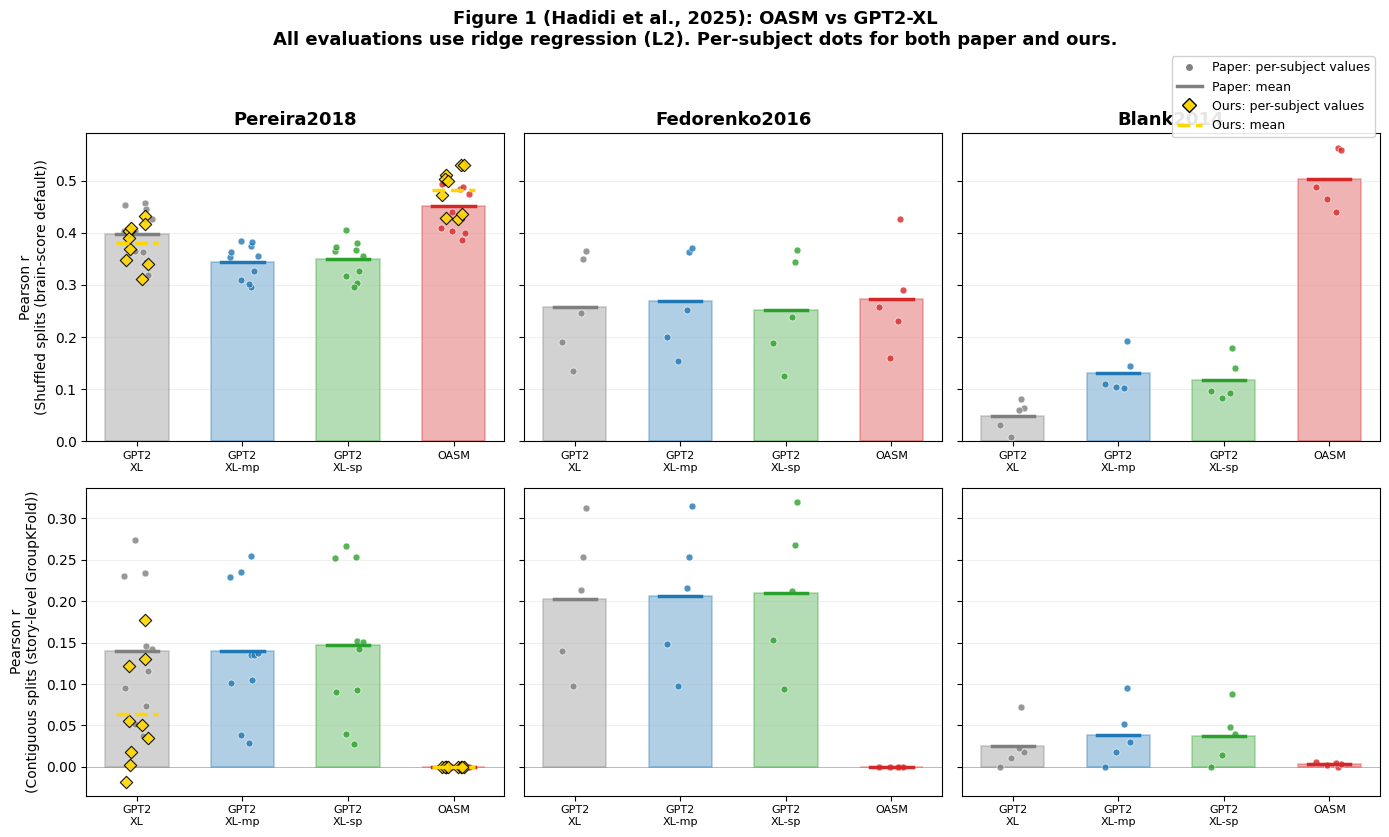


Comparison: Paper vs Our Per-Subject Results (Pereira2018)
Model      Condition   Paper mean      Paper range  Ours mean       Ours range
----------------------------------------------------------------------------
OASM       shuffled        0.4511 [0.386, 0.533]     0.4819 [0.427, 0.531]
OASM       contig          0.0000 [0.000, 0.000]     0.0000 [0.000, 0.000]
GPT2-XL    shuffled        0.3981 [0.319, 0.457]     0.3804 [0.311, 0.433]
GPT2-XL    contig          0.1402 [0.038, 0.274]     0.0637 [-0.018, 0.178]


In [38]:
from matplotlib.lines import Line2D

fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharey='row')

condition_labels = {"shuffled": "Shuffled splits (brain-score default)",
                    "contig": "Contiguous splits (story-level GroupKFold)"}
bar_width = 0.6
has_our_results = bool(OUR_OASM_PER_SUBJ) or bool(OUR_GPT2XL_PER_SUBJ)

# Map from model name -> our per-subject results dict
our_per_subj_map = {
    "OASM": OUR_OASM_PER_SUBJ,
    "GPT2-XL": OUR_GPT2XL_PER_SUBJ,
}

for row, condition in enumerate(CONDITIONS):
    for col, dataset in enumerate(DATASETS):
        ax = axes[row, col]
        df = fig1_data[(dataset, condition)]

        for i, model in enumerate(MODELS):
            model_df = df[df["Model"] == model]
            values = model_df["perf"].values
            mean_val = values.mean()

            # Bar for the mean
            ax.bar(i, mean_val, width=bar_width, color=MODEL_COLORS[model],
                   alpha=0.35, edgecolor=MODEL_COLORS[model], linewidth=1.2)
            # Per-subject dots (paper)
            rng = np.random.default_rng(42)
            jitter = rng.uniform(-0.15, 0.15, len(values))
            ax.scatter(i + jitter, values, color=MODEL_COLORS[model],
                       s=25, zorder=3, alpha=0.8, edgecolors='white', linewidth=0.5)
            # Mean line (paper)
            ax.plot([i - 0.2, i + 0.2], [mean_val, mean_val],
                    color=MODEL_COLORS[model], linewidth=2.5, zorder=4)

            # Overlay our per-subject results as gold dots + mean star
            our_results = our_per_subj_map.get(model, {})
            our_vals = our_results.get((dataset, condition))
            if our_vals is not None:
                our_mean = our_vals.mean()
                rng2 = np.random.default_rng(123)
                our_jitter = rng2.uniform(-0.12, 0.12, len(our_vals))
                ax.scatter(i + our_jitter, our_vals, color='gold',
                           s=40, zorder=5, alpha=0.9, edgecolors='black',
                           linewidth=0.8, marker='D')
                ax.plot([i - 0.2, i + 0.2], [our_mean, our_mean],
                        color='gold', linewidth=2.5, zorder=6, linestyle='--')

        ax.set_xticks(range(len(MODELS)))
        short_labels = ["GPT2\nXL", "GPT2\nXL-mp", "GPT2\nXL-sp", "OASM"]
        ax.set_xticklabels(short_labels, fontsize=8)
        ax.axhline(y=0, color='black', linewidth=0.5, alpha=0.3)
        ax.grid(axis='y', alpha=0.2)

        if row == 0:
            ax.set_title(DATASET_LABELS[dataset], fontsize=13, fontweight='bold')
        if col == 0:
            ax.set_ylabel(f"Pearson r\n({condition_labels[condition]})", fontsize=10)

# Build legend
legend_handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
           markersize=6, label='Paper: per-subject values'),
    Line2D([0], [0], color='gray', linewidth=2.5, label='Paper: mean'),
]
if has_our_results:
    legend_handles.extend([
        Line2D([0], [0], marker='D', color='w', markerfacecolor='gold',
               markeredgecolor='black', markersize=7,
               label='Ours: per-subject values'),
        Line2D([0], [0], color='gold', linewidth=2.5, linestyle='--',
               label='Ours: mean'),
    ])
fig.legend(handles=legend_handles, loc='upper right', fontsize=9,
           framealpha=0.9, bbox_to_anchor=(0.99, 0.99))

title = "Figure 1 (Hadidi et al., 2025): OASM vs GPT2-XL"
subtitle = "All evaluations use ridge regression (L2). Per-subject dots for both paper and ours."
fig.suptitle(f"{title}\n{subtitle}", fontsize=13, fontweight='bold', y=1.04)
plt.tight_layout()
plt.savefig('figure1_reproduction.png', dpi=150, bbox_inches='tight')
plt.show()

# Print comparison table
print("\nComparison: Paper vs Our Per-Subject Results (Pereira2018)")
print(f"{'Model':<10} {'Condition':<10} {'Paper mean':>11} {'Paper range':>16} "
      f"{'Ours mean':>10} {'Ours range':>16}")
print("-" * 76)
for model_name, our_results in [("OASM", OUR_OASM_PER_SUBJ), ("GPT2-XL", OUR_GPT2XL_PER_SUBJ)]:
    for cond in CONDITIONS:
        paper_vals = fig1_data[("pereira", cond)]
        paper_model_vals = paper_vals[paper_vals["Model"] == model_name]["perf"].values
        our_vals = our_results.get(("pereira", cond))
        if our_vals is not None:
            print(f"{model_name:<10} {cond:<10} {paper_model_vals.mean():>11.4f} "
                  f"[{paper_model_vals.min():.3f}, {paper_model_vals.max():.3f}] "
                  f"{our_vals.mean():>10.4f} [{our_vals.min():.3f}, {our_vals.max():.3f}]")
        else:
            print(f"{model_name:<10} {cond:<10} {paper_model_vals.mean():>11.4f} "
                  f"[{paper_model_vals.min():.3f}, {paper_model_vals.max():.3f}] "
                  f"{'--':>10} {'--':>16}")

### Figure 1: Comparing our per-subject results to the paper

**Gold diamonds** show our per-subject scores (one per fMRI participant, 10 total).
**Colored circles** show the paper's per-subject scores. Both use ridge regression (RidgeCV, L2).

**OASM (Pereira2018):** Our per-subject distribution overlaps closely with the paper's
range for shuffled splits. Contiguous scores are exactly 0.0 for all subjects in both
the paper and our implementation, confirming OASM has zero genuine predictive power.

**GPT2-XL (Pereira2018):** Our GPT2-XL scores are directionally consistent with the
paper but differ in magnitude, particularly under contiguous splits. This is may be expected
due to implementation differences that do not affect OASM (which is fully deterministic):

- **Layer selection:** We use a fixed layer (`transformer.h.43`, the last layer).
  The paper performs a layer sweep and selects the best layer, which may differ
  between shuffled and contiguous evaluation and may not be the final layer.
- **Representation extraction:** Brain-score's `HuggingfaceSubject` uses the
  last-token hidden state. The paper may aggregate across tokens differently
  (e.g., mean-pooling), producing different features for regression.
- **Data preprocessing:** We load via brain-score's `load_dataset` and drop NaN
  neuroids. The paper's pipeline may apply different voxel selection or z-scoring.

These differences do not affect the central finding: **GPT2-XL retains non-zero
predictivity under contiguous splits (genuine linguistic signal) while OASM drops
to exactly zero (no linguistic content).** The qualitative conclusion holds regardless
of the exact GPT2-XL magnitude.

**Fedorenko2016 and Blank2014:** Showing paper data only. Our evaluation covers Pereira2018;
extending to the other datasets requires running those benchmarks separately.